To get the parallel stuff to work, you need to go into the terminal in whichever environment you are in and type 'ipcluster start --n=60' where n is the number of engines. Need to have ipyparallel and ipcluster installed. 

In [1]:
import pandas as pd
import hddm
import scipy as sp
import seaborn as sns
import os
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% load_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)
%R library(ppcor)

/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: estimability

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/envs/p

array(['ppcor', 'MASS', 'afex', 'reshape2', 'lme4', 'Matrix', 'lsmeans',
       'estimability', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S12')

In [2]:
import ipyparallel as ipp
from ipyparallel import Client

c = ipp.Client(timeout=100)
view = c.load_balanced_view()

In [3]:
%%px --local
# if you don't do this then the 60 nodes can't find accumodel
import accumodel
#accumodel.set_estimator(accumodel.estimators.OptimizeEstimator(accumodel.models.WaldAntiStopFixedThres))
accumodel.set_estimator(accumodel.estimators.OptimizeEstimator(accumodel.models.WaldAntiStop))

Initializing random numbers as (10000, 3)
[stdout:0] Initializing random numbers as (10000, 3)
[stdout:1] Initializing random numbers as (10000, 3)
[stdout:2] Initializing random numbers as (10000, 3)
[stdout:3] Initializing random numbers as (10000, 3)
[stdout:4] Initializing random numbers as (10000, 3)
[stdout:5] Initializing random numbers as (10000, 3)
[stdout:6] Initializing random numbers as (10000, 3)
[stdout:7] Initializing random numbers as (10000, 3)
[stdout:8] Initializing random numbers as (10000, 3)
[stdout:9] Initializing random numbers as (10000, 3)
[stdout:10] Initializing random numbers as (10000, 3)
[stdout:11] Initializing random numbers as (10000, 3)
[stdout:12] Initializing random numbers as (10000, 3)
[stdout:13] Initializing random numbers as (10000, 3)
[stdout:14] Initializing random numbers as (10000, 3)
[stdout:15] Initializing random numbers as (10000, 3)
[stdout:16] Initializing random numbers as (10000, 3)
[stdout:17] Initializing random numbers as (10000,

[stderr:0] 
/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
[stderr:1] 
/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
[stderr:2] 
/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
[stderr:3] 
/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.paralle

# Flanker Depressed

In [4]:
clin_data = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Clin_s1_Mar-16-1002AM-2017.csv')
use = clin_data[clin_data.flanker_qc == 1] # only use these people
subs_to_use = use.ProjectSpecificID.unique()

In [5]:
# load in the data and put it in the correct format for ddm
data = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Clin_s1_Mar-16-1002AM-2017.csv')
data['rt'] /= 1000.
data['response'] = data.accuracy
data['subj_idx'] = data.ProjectSpecificID
data['conf'] = False
data['cond'] = 'incong'
data.loc[data.stimulus == 'CON', 'cond'] = 'cong'
data.loc[data.cond == 'incong', 'conf'] = True

#data = data[data.outlier == 0] # accumodel has it built in to take out the outliers

data = hddm.utils.flip_errors(data)
data.ix[data.conf, 'rt'] *= -1

#data = data.loc[data.ProjectSpecificID == 'CU0009'] # remove the people who should be excluded based on qc fails
data = data.loc[data.ProjectSpecificID.isin(subs_to_use)] # remove the people who should be excluded based on qc fails

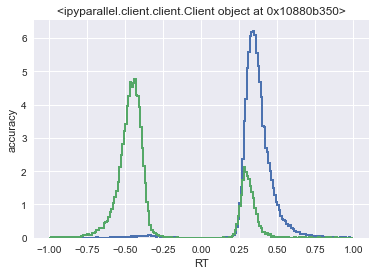

In [6]:
import seaborn as sns
% matplotlib inline 
ax = sns.plt.subplot(1, 1, 1, xlabel='RT', ylabel='accuracy', title=c)
data.ix[data.cond == 'cong', 'rt'].hist(bins=200, histtype='step', range=(-1, 1), normed=True, lw=2, ax=ax);
(data.ix[data.cond == 'incong', 'rt']).hist(bins=200, histtype='step', range=(-1, 1), normed=True, lw=2, ax=ax);

In [4]:
%px import socket; print(socket.gethostname())

[stdout:0] mlms-imac.mclean.harvard.edu
[stdout:1] mlms-imac.mclean.harvard.edu
[stdout:2] mlms-imac.mclean.harvard.edu
[stdout:3] mlms-imac.mclean.harvard.edu
[stdout:4] mlms-imac.mclean.harvard.edu
[stdout:5] mlms-imac.mclean.harvard.edu
[stdout:6] mlms-imac.mclean.harvard.edu
[stdout:7] mlms-imac.mclean.harvard.edu
[stdout:8] mlms-imac.mclean.harvard.edu
[stdout:9] mlms-imac.mclean.harvard.edu
[stdout:10] mlms-imac.mclean.harvard.edu
[stdout:11] mlms-imac.mclean.harvard.edu
[stdout:12] mlms-imac.mclean.harvard.edu
[stdout:13] mlms-imac.mclean.harvard.edu
[stdout:14] mlms-imac.mclean.harvard.edu
[stdout:15] mlms-imac.mclean.harvard.edu
[stdout:16] mlms-imac.mclean.harvard.edu
[stdout:17] mlms-imac.mclean.harvard.edu
[stdout:18] mlms-imac.mclean.harvard.edu
[stdout:19] mlms-imac.mclean.harvard.edu
[stdout:20] mlms-imac.mclean.harvard.edu
[stdout:21] mlms-imac.mclean.harvard.edu
[stdout:22] mlms-imac.mclean.harvard.edu
[stdout:23] mlms-imac.mclean.harvard.edu
[stdout:24] mlms-imac.mcle

In [7]:
# this goes through each subject in the csv and creates a new csv with the parameters for each of the subjects

for sub in data.ProjectSpecificID.unique():
    sub_data = data.loc[data.ProjectSpecificID == sub]
    res_dep = view.map_sync(lambda x: accumodel.models.estimate_subj(x),
                            sub_data.groupby('subj_idx'))
    res_dep_df = pd.concat([pd.DataFrame(r).T for r in res_dep])
    res_dep_df.to_csv('fits_flanker_' + sub + '.csv', index=True)

In [33]:
# go through all of these individual csvs and make one large df

file_list = !ls TW_components/*csv
tw_df = pd.DataFrame()
for file in file_list:
    tw_df = tw_df.append(pd.read_csv(file))
tw_df.rename(columns={'Unnamed: 0': 'ProjectSpecificID'}, inplace=True)

In [34]:
tw_df.head()

,ProjectSpecificID,t,a,v_pro,v_stop,v_anti,t_anti
0,CU0009,0.243810,0.830434,5.513486,8.782450,13.633526,0.158691
0,CU0011,0.240681,1.410445,7.384086,11.147636,7.677219,0.085399
0,CU0013,0.202924,1.198627,8.063158,10.480167,9.406476,0.135845
0,CU0014,0.254951,0.475997,4.209409,5.397583,5.978123,0.135637
0,CU0016,0.237211,1.357512,6.812568,10.929441,7.290664,0.106280


In [35]:
# merge with the clinical data
clin_df = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/groups.csv')
tw_merged = tw_df.merge(clin_df, on='ProjectSpecificID')

In [36]:
tw_merged.head()

,ProjectSpecificID,t,a,v_pro,v_stop,v_anti,t_anti,sample,feasibility,trainingset,...,hamd_28,hamd_29,hamd_30,hamd_31,hamd_32,hamd_33,hamd_34,hamd_35,hamd_36,hamd_score_24
0,CU0009,0.243810,0.830434,5.513486,8.782450,13.633526,0.158691,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CU0011,0.240681,1.410445,7.384086,11.147636,7.677219,0.085399,1.0,3.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,12.0
2,CU0013,0.202924,1.198627,8.063158,10.480167,9.406476,0.135845,2.0,4.0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
3,CU0014,0.254951,0.475997,4.209409,5.397583,5.978123,0.135637,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,21.0
4,CU0016,0.237211,1.357512,6.812568,10.929441,7.290664,0.106280,1.0,3.0,1.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,23.0,34.0


In [13]:
old_ppl = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/depressed_flanker_tw.csv')
old_ppl.head()

,Unnamed: 0,subj_idx,site,subject,session,group,block,trial,stimulus,response,accuracy,rt,feedback,response_side,cond
0,0,CU0009,CU,9,1,0,1,1,INC,1.0,1.0,0.541,Blank,right,incong
1,1,CU0009,CU,9,1,0,1,2,CON,1.0,1.0,0.502,Blank,left,cong
2,2,CU0009,CU,9,1,0,1,3,INC,0.0,0.0,0.379,Blank,right,incong
3,3,CU0009,CU,9,1,0,1,4,CON,1.0,1.0,0.379,Blank,right,cong
4,4,CU0009,CU,9,1,0,1,5,INC,1.0,1.0,0.491,Blank,left,incong


In [38]:
tw_merged['feasibility'].replace(to_replace = 1.0,value = 'MDD', inplace = True) 
tw_merged['feasibility'].replace(to_replace = 3.0,value = 'MDD', inplace = True) 
tw_merged['feasibility'].replace(to_replace = 5.0,value = 'MDD', inplace = True) 
tw_merged['feasibility'].replace(to_replace = 4.0,value = 'CTL', inplace = True) 

Before looking at the results with everyone, I want to look at just the people that were included in the 2015 paper, to make sure the parameters are the same. 

In [39]:
# get the subject IDs for the people that were included in the first paper from the csv that tw sent
data_tw_peeps = tw_merged[tw_merged.ProjectSpecificID.isin(old_ppl.subj_idx.unique())]

# Do we have 37 controls and 92 MDDs as reported in the paper?
# YES
data_tw_peeps.groupby('feasibility').ProjectSpecificID.nunique()

feasibility
CTL    37
MDD    92
Name: ProjectSpecificID, dtype: int64

In [40]:
list_of_params = ['t', 'v_pro', 'v_stop', 'v_anti', 't_anti', 'a']
d = {}
for param in list_of_params:
    results = sp.stats.ttest_ind(data_tw_peeps[(data_tw_peeps.feasibility == 'MDD')][param],
            data_tw_peeps[(data_tw_peeps.feasibility == 'CTL')][param])
    means = data_tw_peeps.groupby('feasibility')[param].mean()
    p = {}
    p['statistic'] = results[0]
    p['pvalue'] = results[1]
    p['MDD_mean'] = means[1]
    p['CTL_mean'] = means[0]
    d[param] = p
df = pd.DataFrame.from_dict(d, orient='index')
df

,CTL_mean,MDD_mean,pvalue,statistic
a,1.028934,1.160762,0.097857,1.667611
t,0.213950,0.205497,0.415732,-0.816520
t_anti,0.128966,0.138768,0.141640,1.478911
v_anti,10.148298,9.322486,0.106415,-1.626062
v_pro,6.984221,6.414638,0.022839,-2.304145
v_stop,9.760866,9.685562,0.850732,-0.188569


The above df is slightly different from the table 1 in the 2015 paper. The v_pro difference is still significant here, but there's no v_anti group difference. There aren't any huge differences between the means here and the means in the paper, but they aren't exactly the same and I'm not really sure why. At first I thought it was because we included the outlier trials, but then I redid it removing those (see TW_components_new folder) and that didn't fix the problem. Accumodels removes the outliers on its own, so they shouldn't be removed beforehand anyway.  
  
What about the correlations that were found in the first paper?

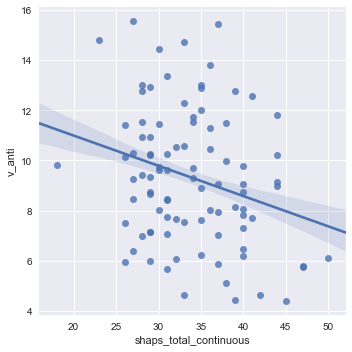

In [41]:
# Does the correlation w/ shaps + v_anti found in the first paper look generally the same?
# Yes, though note that the v_anti scores are not exactly the same. That low shaps is TX0096, who had a v_anti
# of 8 in the paper

executive_shaps = sns.lmplot(y = 'v_anti', x = 'shaps_total_continuous', data = data_tw_peeps[data_tw_peeps['feasibility'] == 'MDD'], ci=68)

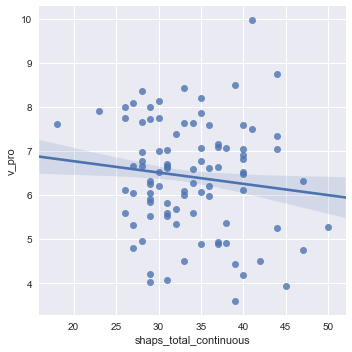

In [42]:
# What about the lack of correlation with v_pro?
# Yes, generally, except for that one really high point, which is UM0027. Nothing looks particularly weird about their data.

prepotent_shaps = sns.lmplot(y = 'v_pro', x = 'shaps_total_continuous', data = data_tw_peeps[data_tw_peeps['feasibility'] == 'MDD'], ci=68)

Is this because our data is different from the first point of analysis?

In [21]:
ours_to_compare = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/to_compare/ours_to_compare.csv')
tw_to_compare = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/to_compare/tw_to_compare.csv')

In [22]:
ours_to_compare = ours_to_compare[ours_to_compare.ProjectSpecificID.isin(old_ppl.subj_idx.unique())]

In [23]:
ours_to_compare.head()

,ProjectSpecificID,site,subject,session,group,block,trial,stimulus,response,accuracy,rt,feedback
0,CU0009,CU,9,1,CTL,1,1,INC,1.0,1.0,0.541,Blank
1,CU0009,CU,9,1,CTL,1,2,CON,1.0,1.0,0.502,Blank
2,CU0009,CU,9,1,CTL,1,3,INC,0.0,0.0,0.379,Blank
3,CU0009,CU,9,1,CTL,1,4,CON,1.0,1.0,0.379,Blank
4,CU0009,CU,9,1,CTL,1,5,INC,1.0,1.0,0.491,Blank


In [24]:
tw_to_compare.head()

,ProjectSpecificID,site,subject,session,group,block,trial,stimulus,response,accuracy,rt,feedback
0,CU0009,CU,9,1,CTL,1,1,INC,1.0,1.0,0.541,Blank
1,CU0009,CU,9,1,CTL,1,2,CON,1.0,1.0,0.502,Blank
2,CU0009,CU,9,1,CTL,1,3,INC,0.0,0.0,0.379,Blank
3,CU0009,CU,9,1,CTL,1,4,CON,1.0,1.0,0.379,Blank
4,CU0009,CU,9,1,CTL,1,5,INC,1.0,1.0,0.491,Blank


In [25]:
tw_to_compare['group'].replace(to_replace = '1',value = 'MDD', inplace = True) 
tw_to_compare['group'].replace(to_replace = '0',value = 'CTL', inplace = True) 

In [26]:
# Returns whether or not the two dataframes are the same. It was returning false before b/c the groups are were named 
# differently in the two files (0/1 vs CTL/MDD), and one file had an index. Now that that's removed, it's saying that 
# the two dfs are the same. Also confirmed with sdiff. 
ours_to_compare.equals(tw_to_compare)

True

Even though we'll have to redo once we figure out why the parameters are off, lets look at the parameters with all of the subjects.

In [44]:
tw_merged.groupby('feasibility').ProjectSpecificID.nunique()

feasibility
CTL     37
MDD    266
Name: ProjectSpecificID, dtype: int64

In [17]:
list_of_params = ['t', 'v_pro', 'v_stop', 'v_anti', 't_anti', 'a']
d = {}
for param in list_of_params:
    results = sp.stats.ttest_ind(tw_merged[(tw_merged.feasibility == 'MDD')][param],
            tw_merged[(tw_merged.feasibility == 'CTL')][param])
    means = tw_merged.groupby('feasibility')[param].mean()
    p = {}
    p['statistic'] = results[0]
    p['pvalue'] = results[1]
    p['MDD_mean'] = means[1]
    p['CTL_mean'] = means[0]
    d[param] = p
df = pd.DataFrame.from_dict(d, orient='index')
df

,CTL_mean,MDD_mean,pvalue,statistic
a,1.028934,1.145665,0.088640,1.708149
t,0.213950,0.204129,0.248196,-1.156985
t_anti,0.128966,0.139264,0.066469,1.841928
v_anti,10.148298,9.847350,0.545006,-0.605948
v_pro,6.984221,6.640195,0.167130,-1.384830
v_stop,9.760866,9.773845,0.971852,0.035315


What about the correlations?

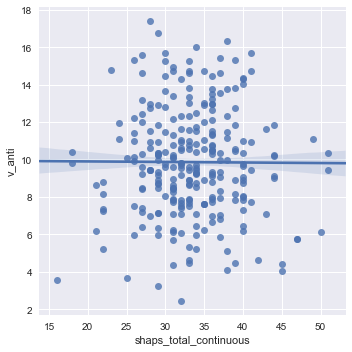

In [21]:
# Does the v_anti correlation remain? 
# No

executive_shaps = sns.lmplot(y = 'v_anti', x = 'shaps_total_continuous', data = tw_merged[tw_merged['feasibility'] == 'MDD'], ci=68)

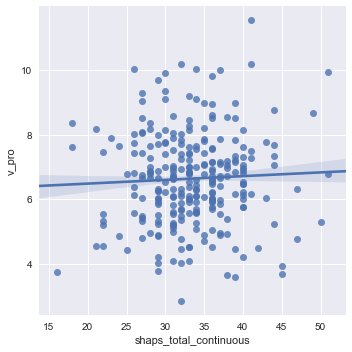

In [22]:
# And v_pro?

prepotent_shaps = sns.lmplot(y = 'v_pro', x = 'shaps_total_continuous', data = tw_merged[tw_merged['feasibility'] == 'MDD'], ci=68)